## Tensor Network Transfer Learning

Imports

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# Path to folder containing .npz files
folder_path = 'data/transfer_learning_tdvp'

# List all .npz files
npz_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]

# Load each file
zs=[]
hs=[]
for file_name in npz_files:
    file_path = os.path.join(folder_path, file_name)
    data = np.load(file_path)
    
    #print(f"Loaded {file_name}")
    #print(f"Keys: {list(data.keys())}")
    hs.append(data['drivings'])
    zs.append(data['z_values'])
    time=data['time']
    # Example: access array by key
    # array = data['some_array_key']
hs=np.asarray(hs).reshape(-1,time.shape[0])
zs=np.asarray(zs).reshape(-1,time.shape[0])

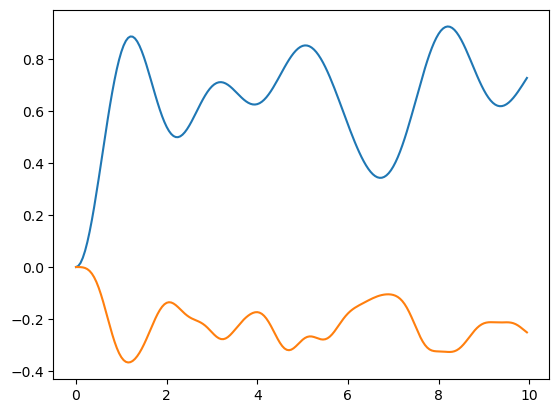

In [43]:
idx=np.random.randint(0,hs.shape[0])
plt.plot(time,hs[idx])
plt.plot(time,zs[idx])
plt.show()

#### Compute the $h_{eff}$

In [125]:
from src.tddft_methods.tddft_solver import Driving,second_derivative_formula
from tqdm import trange
from scipy.sparse.linalg import eigsh,expm

derivative_formula='9-points'
pbc=True

# New extended time grid
steps_tddft=1000
l=1
time_tddft = np.linspace(0, 10, steps_tddft)  # longer than original

# Allocate array for new drivings
drivings_new = np.zeros((hs.shape[0], len(time_tddft)))
magnetization_new=np.zeros((hs.shape[0], len(time_tddft)))
# Interpolate each batch element
for i in range(hs.shape[0]):
    f = interp1d(time, hs[i], kind='cubic', fill_value='extrapolate')
    g= interp1d(time, zs[i], kind='cubic', fill_value='extrapolate')
    drivings_new[i] = f(time_tddft)
    magnetization_new[i]=g(time_tddft)


In [ ]:
z_reconstruction=np.zeros((hs.shape[0],steps_tddft,l))
h_eff_vector=np.zeros((hs.shape[0],steps_tddft,l))
for q in range(100):
    # compute the effective field
    psi=np.zeros((2,l))
    z_exp=magnetization_new[q][:,None]*np.ones(l)[None,:]
    psi[0] = np.sqrt((1 + z_exp[0]) / 2)
    psi[1] = np.sqrt((1 - z_exp[0]) / 2)

    omega=1.
    j=-1
    # build up the operators
    x_op=np.array([[0.,1.],[1.,0]])
    z_op=np.array([[1.,0.],[0.,-1.]])


    # extrapolate the fields
    #f=interp1d(time,z_exp,axis=0)
    #z_tddft=f(time_tddft)
    z_tddft=z_exp
    current_derivative_tddft=second_derivative_formula(z_tddft,dt=time_tddft[1]-time_tddft[0],derivative_formula=derivative_formula)



    dt=time_tddft[1]-time_tddft[0]    


    for i in trange(steps_tddft):
        psi_r=psi.copy()
        for f in range(1):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
            z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
            
            if pbc:
                #pbc
                nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            
            else:
                #obc
                shift_plus=np.zeros(l)
                shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
                shift_minus=np.zeros(l)
                shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
                #print(shift_minus,shift_plus)
                nonlinear_term=np.abs(j)*(shift_plus+shift_minus)+omega+10**-10
            h_eff=(0.25*current_derivative_tddft[i]/nonlinear_term+z_tddft[i]*nonlinear_term)/(x_ave+10**-10)
            h_eff_vector[q,i]=h_eff
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff[:,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
            psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
            
            
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        z_reconstruction[q,i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)


In [ ]:
idx=np.random.randint(0,100)
print(idx,z_reconstruction.shape)
plt.plot(time_tddft,z_reconstruction[idx,:,0])
plt.plot(time_tddft,magnetization_new[idx,:])
plt.show()

plt.plot(time_tddft,h_eff_vector[idx,:,0])
plt.show()

In [148]:
print(drivings_new.shape,zs.shape)
input=np.zeros((drivings_new.shape[0],drivings_new.shape[1]+1,1))
output=np.zeros((h_eff_vector.shape[0],h_eff_vector.shape[1]+1,h_eff_vector.shape[2]))
input[:,1:,0]=drivings_new
input[:,0,0]=zs[:,0]

output[:,1:]=h_eff_vector

np.savez('data/transfer_learning_dataset',h_eff=output,h=input)

(100, 1000) (100, 200)


## Perform the transfer Learning

Imports

In [6]:
import torch
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
from typing import List
import torch.nn as nn

torch.set_num_threads(3)

Load the model

In [42]:
models_name=['dataset_2025-06-30_13-44_LSTM_f2f_fixed_initial_state_tf_10_nsteps_1000_250708_dataset_30k_[200]_hc_[5, 1]_ks_0_ps_1_nconv_1_nblock']
models=[]
for i,name in enumerate(models_name):
    model = torch.load(
    "model_rep/"+name,
    map_location="cpu",
    weights_only=False
    )
    model.eval()
    models.append(model)
    print(model)

BiLSTMModel(
  (bilstm): LSTM(1, 200, batch_first=True, bidirectional=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss): MSELoss()
)


In [43]:
def prepare_transfer_learning(model, freeze_lstm=True):
    """
    Prepares the model for transfer learning.
    :param model: The BiLSTMModel instance.
    :param freeze_lstm: Whether to freeze the LSTM layer.
    :return: Modified model ready for fine-tuning.
    """
    if freeze_lstm:
        for param in model.bilstm.parameters():
            param.requires_grad = False
    else:
        for param in model.bilstm.parameters():
            param.requires_grad = True

    # Optionally reinitialize the final layer if the target changes
    model.fc_layers[-1] = nn.Linear(200, 1)  # Re-initialize last Linear layer

    return model

In [41]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    for batch in dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device).float(), targets.to(device).float()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)

    return total_loss / len(dataloader.dataset)

In [44]:
transfer_model = prepare_transfer_learning(models[0], freeze_lstm=True)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model.to(device)

# Define optimizer for training
trainable_params = filter(lambda p: p.requires_grad, transfer_model.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=1e-4)
criterion = nn.MSELoss()

In [45]:
def train_model(model, dataloader, optimizer, criterion, device, num_epochs=20, val_dataloader=None):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device).float(), targets.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs).float()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

        # Optional: Validation
        if val_dataloader is not None:
            val_loss = evaluate_model(model, val_dataloader, criterion, device)
            print(f"           Validation Loss: {val_loss:.4f}")

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
training_window=501
split_value=0.9


data=np.load('data/dataset_h_eff/new_analysis_xxzx_model/transfer_learning_dataset.npz')

val_split=int(split_value*data['h'].shape[0])
x=data['h'][:val_split,:training_window]
y=data['h_eff'][:val_split,:training_window]

x_val=data['h'][val_split:,:]
y_val=data['h_eff'][val_split:,:]

dataset = TensorDataset(torch.from_numpy(x), torch.from_numpy(y))
val_dataset=TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


KeyError: 'time is not a file in the archive'

In [48]:
# Assuming train_loader is defined
train_model(transfer_model.float(), train_loader, optimizer, criterion, device, num_epochs=500,val_dataloader=val_loader)

Epoch [1/500], Train Loss: 0.0451
           Validation Loss: 0.0490
Epoch [2/500], Train Loss: 0.0432
           Validation Loss: 0.0467
Epoch [3/500], Train Loss: 0.0413
           Validation Loss: 0.0445
Epoch [4/500], Train Loss: 0.0398
           Validation Loss: 0.0424
Epoch [5/500], Train Loss: 0.0378
           Validation Loss: 0.0404
Epoch [6/500], Train Loss: 0.0364
           Validation Loss: 0.0385
Epoch [7/500], Train Loss: 0.0349
           Validation Loss: 0.0368
Epoch [8/500], Train Loss: 0.0334
           Validation Loss: 0.0351
Epoch [9/500], Train Loss: 0.0324
           Validation Loss: 0.0335
Epoch [10/500], Train Loss: 0.0310
           Validation Loss: 0.0320
Epoch [11/500], Train Loss: 0.0299
           Validation Loss: 0.0305
Epoch [12/500], Train Loss: 0.0289
           Validation Loss: 0.0292
Epoch [13/500], Train Loss: 0.0276
           Validation Loss: 0.0279
Epoch [14/500], Train Loss: 0.0266
           Validation Loss: 0.0267
Epoch [15/500], Train Loss: 0

#### Test the transfer model

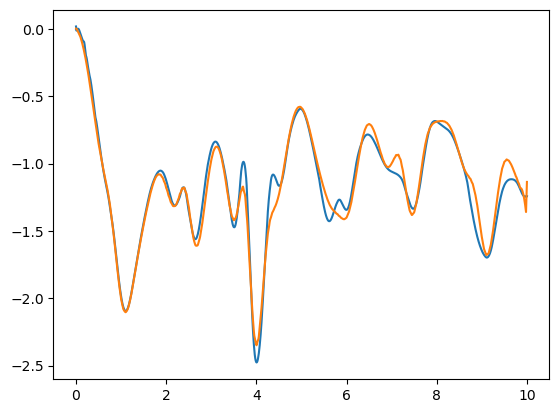

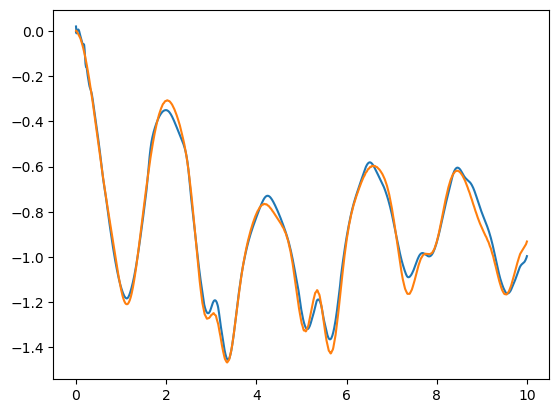

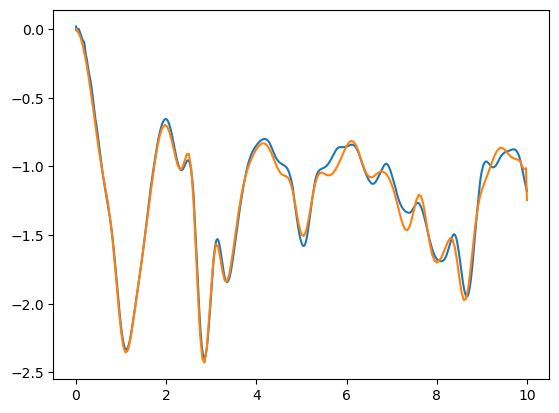

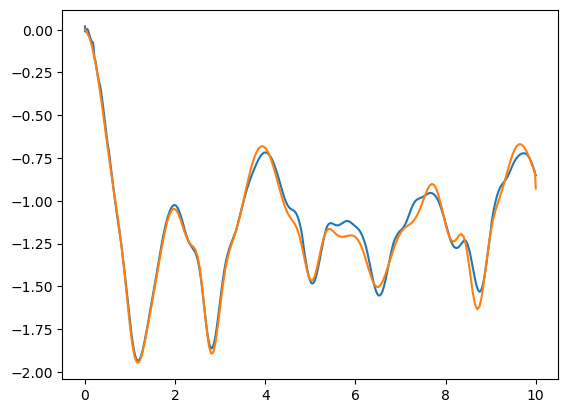

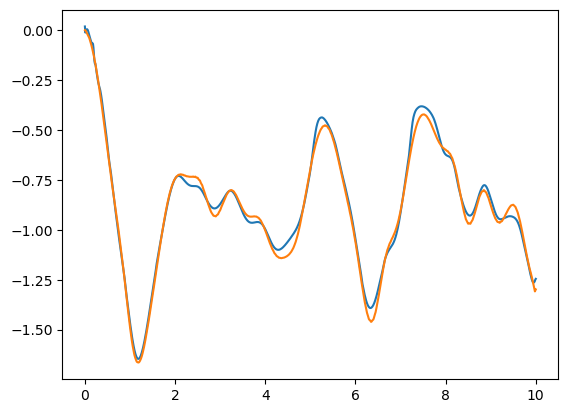

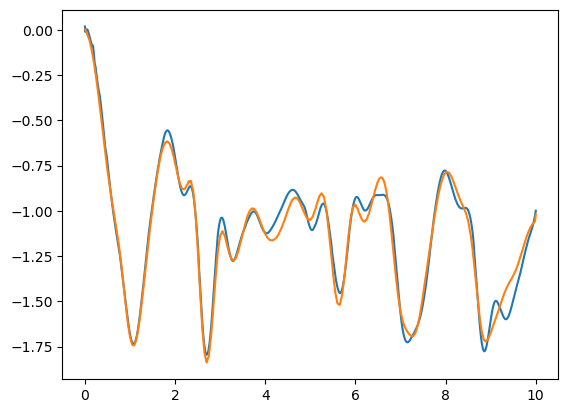

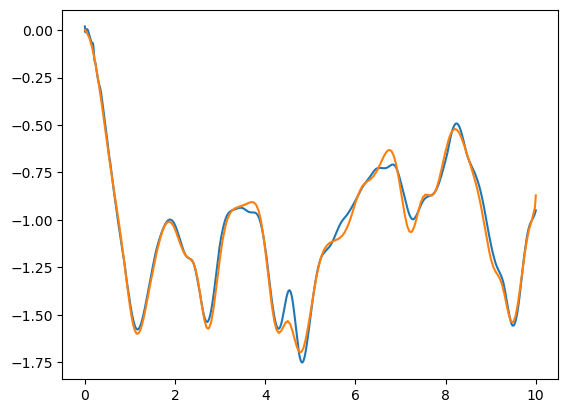

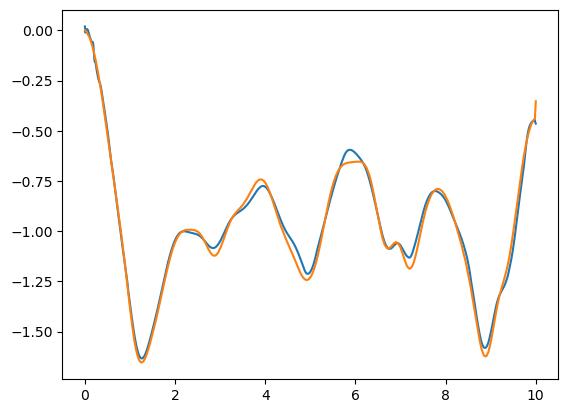

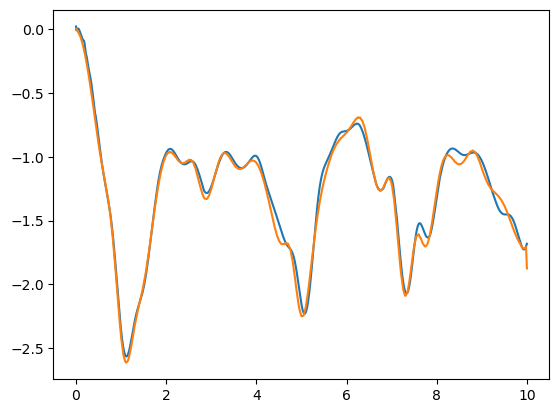

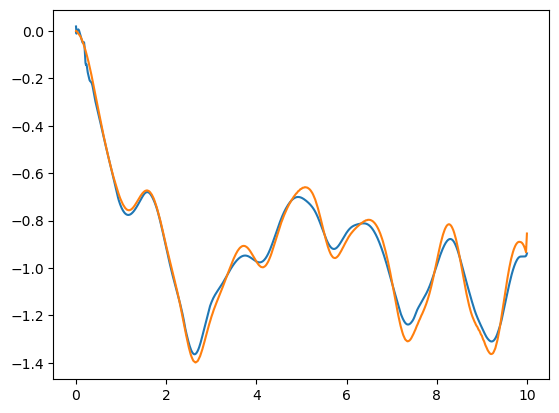

In [54]:
transfer_model=transfer_model.to(device='cpu')
h_eff_pred=transfer_model(torch.from_numpy(x_val).cpu().float()).detach().cpu().numpy()
time=np.linspace(0,10,1000)

for i in range(h_eff_pred.shape[0]):
    plt.plot(time,h_eff_pred[i,1:,0])
    plt.plot(time,y_val[i,1:,0])
    plt.show()
